In [1]:
import numpy as np
import torch as pt
import matplotlib.pyplot as plt
import sys
from pathlib import Path
sys.path.append(Path('../src'))
from src.molecular_hamiltonian import Molecular_Hamiltonian
from src.bf_quantum_state import BFQuantumState
import src.constants
import math

First we compute the ground states and ground state energies and store them for later use.

In [ ]:
molecules = ['H2', 'LiH', 'H2O', 'NH3']
for molecule in molecules:
    save_direc_eigs = Path('data/Diagonal_hamiltonian/molecule_'+ molecule + '_eigenvalues_first.npy')
    save_direc_groundstate = Path('data/Diagonal_hamiltonian/molecule_'+ molecule + '_groundstate_dict.npy')
    energy_eig_vals, eigvecs = Molecular_Hamiltonian(molecule).diagonalize(1, True)
    ground_state = pt.tensor(eigvecs[:, 0])
    np.save(save_direc_eigs, energy_eig_vals)
    np.save(save_direc_groundstate, ground_state)

Now we do shadow measurements on our ground state and store them to later predict the energy.

In [27]:
molecules = ['NH3']
num_of_measurements = 1500000
measurement_methods = np.array(['randomized'])
for molecule in molecules:
    print('starting molecule ' + molecule)
    save_direc_groundstate = Path('data/Diagonal_hamiltonian/molecule_'+ molecule + '_groundstate_dict.npy')
    ground_state = pt.tensor(np.load(save_direc_groundstate, allow_pickle=True), dtype=src.constants.DEFAULT_COMPLEX_TYPE)
    for l in range(0, 1):
        print('starting measurement method ' + measurement_methods[l])
        observables = Molecular_Hamiltonian(molecule).observables_for_energy_estimation()
        measurement_procedure, measurement_index = BFQuantumState(Molecular_Hamiltonian(molecule).qubit_number_after_jordan_wigner(),
                            ground_state).measurement_shadow(num_of_measurements, measurement_methods[l], observables)
        save_direc_procedure = Path('data/shadow_measurements/procedure_molecule_' + molecule +'_method_'+measurement_methods[l]+'.npy')
        save_direc_index = Path('data/shadow_measurements/index_molecule_' + molecule +'_method_'+measurement_methods[l]+'.npy')
        np.save(save_direc_procedure, measurement_procedure)
        np.save(save_direc_index, measurement_index)

starting molecule NH3
starting measurement method randomized
[['Y', 'X', 'X', 'Z', 'X', 'X', 'X', 'Y', 'Z', 'Z', 'Y', 'X', 'Z', 'X', 'X', 'Y'], ['X', 'Z', 'X', 'X', 'Z', 'Y', 'Y', 'Y', 'Z', 'X', 'X', 'Z', 'Z', 'Z', 'Y', 'Y'], ['Z', 'X', 'X', 'X', 'Z', 'Z', 'Z', 'Y', 'X', 'Z', 'X', 'Z', 'X', 'X', 'Z', 'X'], ['Y', 'Z', 'Y', 'Z', 'Z', 'Z', 'X', 'X', 'X', 'Z', 'X', 'Y', 'Z', 'Y', 'X', 'X'], ['X', 'Y', 'Y', 'Y', 'Y', 'X', 'Y', 'Y', 'Z', 'X', 'X', 'Y', 'Z', 'X', 'Z', 'Y'], ['Z', 'X', 'X', 'Y', 'X', 'Y', 'Z', 'X', 'Y', 'Z', 'X', 'Z', 'Y', 'Z', 'X', 'X'], ['Y', 'Z', 'Y', 'Y', 'Y', 'Z', 'X', 'Y', 'Z', 'Z', 'Z', 'X', 'X', 'Z', 'Z', 'Y'], ['X', 'Z', 'Y', 'Y', 'Z', 'Y', 'X', 'Z', 'X', 'X', 'Y', 'Y', 'Z', 'Y', 'X', 'X'], ['Z', 'X', 'X', 'Z', 'Z', 'Z', 'Z', 'X', 'X', 'Y', 'X', 'Y', 'X', 'X', 'X', 'X'], ['Y', 'X', 'Y', 'Z', 'Y', 'Z', 'X', 'Z', 'Y', 'X', 'X', 'Y', 'Z', 'X', 'Y', 'X'], ['Z', 'Y', 'Z', 'Y', 'Y', 'X', 'Y', 'X', 'X', 'Z', 'Y', 'X', 'Y', 'X', 'X', 'Y'], ['Y', 'Z', 'Y', 'X', 'Z', 'X', 'X', 

In [3]:
# this function converts the stored measurement outcomes to the correct shape needed for the shadow prediction
def conversion_to_prediction_shadow_dict_shape(measurement_procedure, measurement_index, qubit_num):
    to_str_func = np.vectorize(lambda x: np.binary_repr(x).zfill(qubit_num))
    strs = to_str_func(measurement_index)
    dirac_rep = np.zeros(list(measurement_index.shape) + [qubit_num], dtype=np.int8)
    for bit_ix in range(0, qubit_num):
        fetch_bit_func = np.vectorize(lambda x: x[bit_ix] == '1')
        dirac_rep[...,bit_ix] = fetch_bit_func(strs).astype("int8")
    measurement_array = np.where(dirac_rep == 1, -1, dirac_rep)
    measurement_array = np.where(dirac_rep == 0, 1, measurement_array)
    measurement = np.dstack((measurement_procedure, np.array(measurement_array, dtype=int)))
    return measurement

In [9]:
measurement_methods = np.array(['derandomized', 'randomized'])
numbers_of_measurements = np.array([10**3, 10**4, 10**5])
molecules = ['LiH']
for molecule in molecules:
    for l in range(0,1):
        energies_shadow = []
        energies_brute = []
        for num_of_measurements in numbers_of_measurements:
            save_direc_procedure = Path('data/shadow_measurements/procedure_molecule_' + molecule +'_method_'+measurement_methods[l]+'.npy')
            save_direc_index = Path('data/shadow_measurements/index_molecule_' + molecule +'_method_'+measurement_methods[l]+'.npy')
            measurement_procedure = np.lib.format.open_memmap(save_direc_procedure, dtype=np.str_, mode='r')
            measurement_index = np.lib.format.open_memmap(save_direc_index, dtype=np.int32, mode='r')
            measurements = conversion_to_prediction_shadow_dict_shape(measurement_procedure[0:num_of_measurements,:],
                                                                      measurement_index[0:num_of_measurements], Molecular_Hamiltonian(molecule).qubit_number_after_jordan_wigner())
            energy_shadow = Molecular_Hamiltonian(molecule).energy_shadow(measurements)
            save_direc_eigs = Path('data/Diagonal_hamiltonian/molecule_'+ molecule + '_eigenvalues_first.npy')
            energy_brute = np.load(save_direc_eigs, allow_pickle=True)
            energies_shadow.append(energy_shadow)
            energies_brute.append(energy_brute)
            print('exact energie of molecule ' + molecule + ' = ' + str(energy_brute))
            print('energie estimated with ' + measurement_methods[l] + ' shadows of molecule ' + molecule + ' = ' + str(energy_shadow))
            print('relative error: ' + str(np.abs((energy_brute - energy_shadow) / energy_brute)))

exact energie of molecule LiH = [-7.8827622]
energie estimated with derandomized shadows of molecule LiH = (-7.852296681456011+0j)
relative error: [0.00386483]
exact energie of molecule LiH = [-7.8827622]
energie estimated with derandomized shadows of molecule LiH = (-7.864045357456577+0j)
relative error: [0.0023744]
exact energie of molecule LiH = [-7.8827622]
energie estimated with derandomized shadows of molecule LiH = (-7.850095813272143+0j)
relative error: [0.00414403]


Now we plot the relative error in the prediction of the energy $\frac{|E_{exact} - E_{shadow}|}{E_{exact}}$ against the number of measurements.

In [21]:
measurement_methods = np.array(['derandomized', 'randomized'])
numbers_of_measurements = np.array([100, 200, 500, 1000, 2000, 5000, 10000, 20000, 50000])
batches = 30
molecules = ['H20', 'NH3']
try:
    save_direc_rel_errors = Path('data/energy_estimations/molecules_relative_erros_in_energy_prediction_dict.npy')
    all_rel_errors = np.load(save_direc_rel_errors, allow_pickle=True)
    all_rel_errors = all_rel_errors.item()
except:
    all_rel_errors = {}
for molecule in molecules:
    all_rel_errors[molecule] = {}
    save_direc_eigs = Path('data/Diagonal_hamiltonian/molecule_'+ molecule + '_eigenvalues_first.npy')
    energy_brute = float(np.load(save_direc_eigs, allow_pickle=True))
    for l in range(0,2):
        if molecule == 'NH3' and l == 1:
            continue
        rel_errors_in_one_batch = np.zeros((np.size(numbers_of_measurements), batches))
        for b in range(0, batches):
            for n in range(0, np.size(numbers_of_measurements)):
                save_direc_procedure = Path('data/shadow_measurements/procedure_molecule_' + molecule +'_method_'+measurement_methods[l]+'.npy')
                save_direc_index = Path('data/shadow_measurements/index_molecule_' + molecule +'_method_'+measurement_methods[l]+'.npy')
                measurement_procedure = np.lib.format.open_memmap(save_direc_procedure, dtype=np.str_, mode='r')
                measurement_index = np.lib.format.open_memmap(save_direc_index, dtype=np.int32, mode='r')
                measurements = conversion_to_prediction_shadow_dict_shape(measurement_procedure[b*numbers_of_measurements[n]:(b+1)*numbers_of_measurements[n],:],
                                                                          measurement_index[b*numbers_of_measurements[n]:(b+1)*numbers_of_measurements[n]], Molecular_Hamiltonian(molecule).qubit_number_after_jordan_wigner())
                energy_shadow = float(Molecular_Hamiltonian(molecule).energy_shadow(measurements).real)
                rel_errors_in_one_batch[n,b] = np.abs(energy_shadow - energy_brute) / np.abs(energy_brute)
        all_rel_errors[molecule][measurement_methods[l]] = rel_errors_in_one_batch
save_direc_rel_errors = Path('data/energy_estimations/molecules_relative_erros_in_energy_prediction_dict.npy')
np.save(save_direc_rel_errors, all_rel_errors)

The observable [['X', 0], ['X', 1], ['Y', 2], ['Z', 3], ['Z', 4], ['Z', 5], ['Z', 6], ['Y', 7]] has not been measured once.
The observable [['X', 0], ['X', 1], ['Y', 2], ['Z', 3], ['Z', 4], ['Z', 5], ['Z', 6], ['Z', 7], ['Z', 8], ['Z', 9]] has not been measured once.
The observable [['X', 0], ['X', 1], ['X', 3], ['Z', 4], ['Z', 5], ['Z', 6], ['Z', 7], ['Z', 8], ['Z', 9]] has not been measured once.
The observable [['X', 0], ['X', 1], ['Y', 4], ['Z', 5], ['Z', 6], ['Z', 7], ['Z', 8], ['Z', 9]] has not been measured once.
The observable [['X', 0], ['X', 1], ['X', 5], ['Z', 6], ['Z', 7], ['Z', 8], ['Z', 9]] has not been measured once.
The observable [['X', 0], ['X', 1], ['Y', 6], ['Z', 7], ['Z', 8], ['Z', 9]] has not been measured once.
The observable [['X', 0], ['Y', 1], ['Y', 2], ['Z', 3], ['Z', 4], ['Z', 5], ['Z', 6], ['Z', 7], ['Z', 8], ['Z', 9]] has not been measured once.
The observable [['X', 0], ['Y', 1], ['Y', 3], ['Z', 4], ['Z', 5], ['Z', 6], ['Z', 7], ['Z', 8], ['Z', 9]] has no

KeyError: 'randomized'

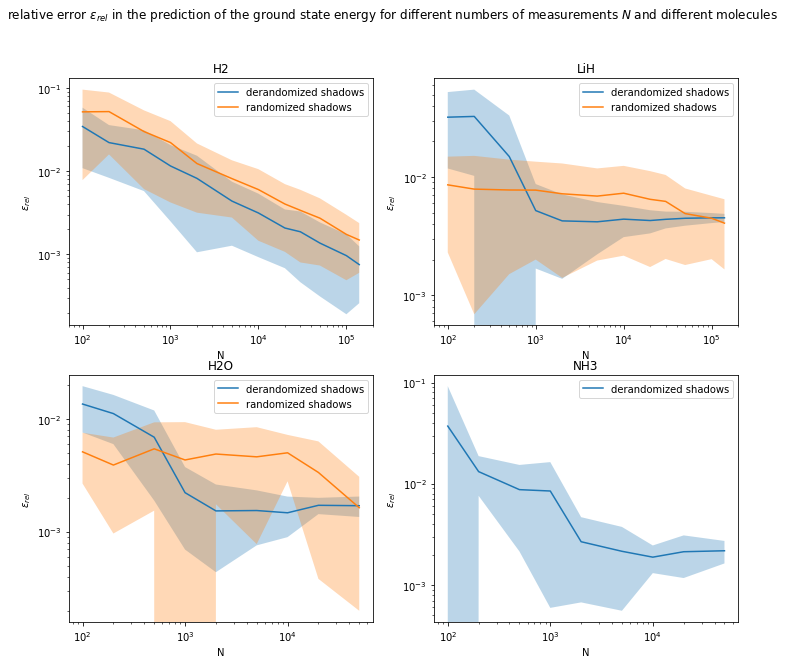

In [25]:
measurement_methods = np.array(['derandomized', 'randomized'])
molecules = ['H2', 'LiH', 'H2O', 'NH3']
fig, axs = plt.subplots(2, 2)
fig.set_figheight(10)
fig.set_figwidth(12)
fig.suptitle('relative error $\epsilon_{rel}$ in the prediction of the ground state energy for different numbers of measurements $N$ and different molecules')
save_direc_rel_errors = Path('data/energy_estimations/molecules_relative_erros_in_energy_prediction_dict.npy')
all_rel_errors_dict = np.load(save_direc_rel_errors, allow_pickle=True)
all_rel_errors_dict = all_rel_errors_dict.item()
for molecule in molecules:
    for l in range(0,2):
        if molecule == 'H2':
            numbers_of_measurements = np.array([100, 200, 500, 1000, 2000, 5000, 10000, 20000, 30000, 50000, 100000, 140000])
            i = 0
            j = 0
        if molecule == 'LiH':
            numbers_of_measurements = np.array([100, 200, 500, 1000, 2000, 5000, 10000, 20000, 30000, 50000, 100000, 140000])
            i = 0
            j = 1
        if molecule == 'H2O':
            numbers_of_measurements = np.array([100, 200, 500, 1000, 2000, 5000, 10000, 20000, 50000])
            i = 1
            j = 0
        if molecule == 'NH3':
            numbers_of_measurements = np.array([100, 200, 500, 1000, 2000, 5000, 10000, 20000, 50000])
            i = 1
            j = 1

        rel_errors = all_rel_errors_dict[molecule][measurement_methods[l]]
        rel_errors_mean = np.mean(rel_errors, axis = 1)
        rel_errors_std = np.std(rel_errors, axis = 1)
        axs[i,j].errorbar(numbers_of_measurements, rel_errors_mean, label = measurement_methods[l] + ' shadows')
        axs[i,j].fill_between(numbers_of_measurements, rel_errors_mean - rel_errors_std, rel_errors_mean + rel_errors_std, alpha = 0.3)
        axs[i,j].set(xscale = 'log', xlabel = 'N', ylabel = '$\epsilon_{rel}$', yscale = 'log')
        axs[i,j].set_title(molecule)
        axs[i,j].legend()

Now we estimate the energy using direct measurements. Later on we will compare the two approaches.

In [16]:
def conversion_to_measurement_outcome_shape(measurement_index, qubit_num):
    to_str_func = np.vectorize(lambda x: np.binary_repr(x).zfill(qubit_num))
    strs = to_str_func(measurement_index)
    dirac_rep = np.zeros(list(measurement_index.shape) + [qubit_num], dtype=np.int8)
    for bit_ix in range(0, qubit_num):
        fetch_bit_func = np.vectorize(lambda x: x[bit_ix] == '1')
        dirac_rep[...,bit_ix] = fetch_bit_func(strs).astype("int8")
    measurement_array = np.where(dirac_rep == 1, -1, dirac_rep)
    measurement_array = np.where(dirac_rep == 0, 1, measurement_array)
    return measurement_array

In [17]:
molecules = ['H2','LiH']
numbers_of_measurements = np.array([100, 200, 500, 1000, 2000, 5000, 10000, 20000, 30000, 50000, 100000, 200000, 500000])
batches = 50
for molecule in molecules:
    numbers_of_measurements_for_each_observable = np.ceil(numbers_of_measurements / len(Molecular_Hamiltonian(molecule).observables_for_energy_estimation()))
    observables_array_shape, coefficients = Molecular_Hamiltonian(molecule).observables_and_coefficients_for_energy_estimation()
    save_direc_groundstate = Path('data/Diagonal_hamiltonian/molecule_'+ molecule + '_groundstate_dict.npy')
    ground_state = pt.tensor(np.load(save_direc_groundstate, allow_pickle=True), dtype=src.constants.DEFAULT_COMPLEX_TYPE)
    save_direc_eigs = Path('data/Diagonal_hamiltonian/molecule_'+ molecule + '_eigenvalues_first.npy')
    energy_brute = float(np.load(save_direc_eigs, allow_pickle=True))
    errors = np.zeros((batches, np.size(numbers_of_measurements_for_each_observable)))
    for k in range(0, batches):
        for j in range(0, np.size(numbers_of_measurements_for_each_observable)):
            errors_all_observables= np.array([])
            energy = 0
            for o in range(0, np.size(observables_array_shape)):
                observable_dict_shape = {}
                if not observables_array_shape[o]:
                    energy = energy + coefficients[o]
                    continue
                for pauli_observable in observables_array_shape[o]:
                    observable_dict_shape[pauli_observable[1]] = str(pauli_observable[0])
                measurement_index, prob = BFQuantumState(Molecular_Hamiltonian(molecule).qubit_number_after_jordan_wigner(), ground_state).measure_pauli(observable_dict_shape, int(numbers_of_measurements_for_each_observable[j]))
                measurement_arrays = conversion_to_measurement_outcome_shape(measurement_index, Molecular_Hamiltonian(molecule).qubit_number_after_jordan_wigner())
                measurement_outcome = 0
                for i in range(0, int(prob.size(dim=0))):
                    measurement_outcome_one_meas = 1
                    for pauli_observable in observables_array_shape[o]:
                        measurement_outcome_one_meas = measurement_outcome_one_meas * measurement_arrays[i][pauli_observable[1]]
                    measurement_outcome = measurement_outcome + prob[i] * measurement_outcome_one_meas
# until here we just obtained the measurement outcome of an arbitrary pauli observable array, now we estimate the energy from this
                energy = energy + coefficients[o] * measurement_outcome
            errors[k,j] = np.abs(energy_brute - energy) / np.abs(energy_brute)
    save_direc_rel_errors_direct_meas = Path('data/energy_estimations/molecule_' + molecule + '_relative_errors_in_energy_prediction_dict_direct_measurements.npy')
    np.save(save_direc_rel_errors_direct_meas, errors)

C:\Users\Lenna\Anaconda3\lib\site-packages\numpy\core\_asarray.py:102: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order)


[0.03681408 0.02099964 0.01295712 0.0102762  0.00808637 0.00494234
 0.00388735 0.00229152 0.001989   0.00186284 0.00135376 0.00088849
 0.00056216]
[0.0246258  0.0241024  0.02194666 0.01640689 0.01181194 0.01021794
 0.00617251 0.00569657 0.00453836 0.00451791 0.0049579  0.00454173
 0.00414088]
[0.03213004 0.03261112 0.01491722 0.00519562 0.00425021 0.00417502
 0.004397   0.00428023 0.00438171 0.00447262 0.00451166 0.00451326]


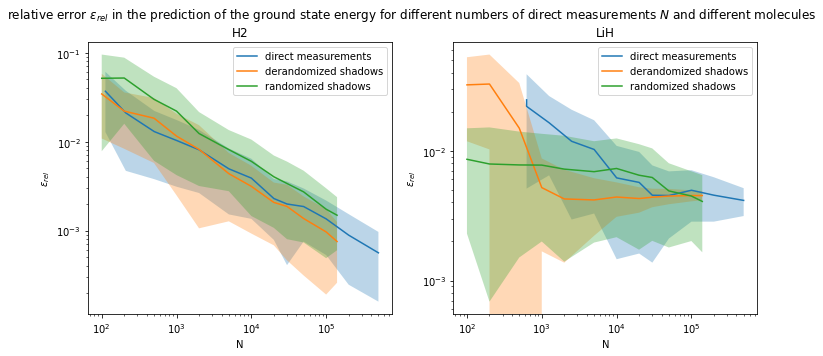

In [80]:
measurement_methods = np.array(['derandomized', 'randomized'])
molecules = ['H2', 'LiH']
fig, axs = plt.subplots(1, 2)
fig.set_figheight(5)
fig.set_figwidth(12)
fig.suptitle('relative error $\epsilon_{rel}$ in the prediction of the ground state energy for different numbers of direct measurements $N$ and different molecules')

save_direc_rel_errors = Path('data/energy_estimations/molecules_relative_erros_in_energy_prediction_dict.npy')
all_rel_errors_dict = np.load(save_direc_rel_errors, allow_pickle=True)
all_rel_errors_dict = all_rel_errors_dict.item()
for molecule in molecules:
    numbers_of_measurements = np.array([100, 200, 500, 1000, 2000, 5000, 10000, 20000, 30000, 50000, 100000, 200000, 500000])
    save_direc_rel_errors_direct_meas = Path('data/energy_estimations/molecule_' + molecule + '_relative_errors_in_energy_prediction_dict_direct_measurements.npy')
    rel_errors = np.load(save_direc_rel_errors_direct_meas, allow_pickle=True)
    numbers_of_measurements_for_each_observable = np.ceil(numbers_of_measurements / len(Molecular_Hamiltonian(molecule).observables_for_energy_estimation()))
    rel_errors_mean = np.mean(rel_errors, axis = 0)
    print(rel_errors_mean)
    rel_errors_std = np.std(rel_errors, axis = 0)
    if molecule == 'H2':
            i = 0
            j = 0
    if molecule == 'LiH':
            i = 0
            j = 1
    if molecule == 'H2O':
            i = 1
            j = 0
    if molecule == 'NH3':
            i = 1
            j = 1
    axs[j].errorbar(numbers_of_measurements_for_each_observable * len(Molecular_Hamiltonian(molecule).observables_for_energy_estimation()), rel_errors_mean, label = 'direct measurements')
    axs[j].fill_between(numbers_of_measurements_for_each_observable * len(Molecular_Hamiltonian(molecule).observables_for_energy_estimation()), rel_errors_mean - rel_errors_std, rel_errors_mean + rel_errors_std, alpha = 0.3)
    axs[j].set(xscale = 'log', xlabel = 'N', ylabel = '$\epsilon_{rel}$', yscale = 'log')
    axs[j].set_title(molecule)
    for l in range(0,2):
        numbers_of_measurements = np.array([100, 200, 500, 1000, 2000, 5000, 10000, 20000, 30000, 50000, 100000, 140000])
        rel_errors = all_rel_errors_dict[molecule][measurement_methods[l]]
        rel_errors_mean = np.mean(rel_errors, axis = 1)
        rel_errors_std = np.std(rel_errors, axis = 1)

        axs[j].errorbar(numbers_of_measurements, rel_errors_mean, label = measurement_methods[l] + ' shadows')
        axs[j].fill_between(numbers_of_measurements, rel_errors_mean - rel_errors_std, rel_errors_mean + rel_errors_std, alpha = 0.3)
        axs[j].set(xscale = 'log', xlabel = 'N', ylabel = '$\epsilon_{rel}$', yscale = 'log')
        axs[j].legend()

rel_errors = all_rel_errors_dict['LiH']['derandomized']
rel_errors_mean = np.mean(rel_errors, axis = 1)
print(rel_errors_mean)

For H2 the derandomized and direct measurement approach perform more or less equally good because the four 4-local Pauli strings [['X', 0], ['X', 1], ['Y', 2], ['Y', 3]],
 [['X', 0], ['Y', 1], ['Y', 2], ['X', 3]],
 [['Y', 0], ['X', 1], ['X', 2], ['Y', 3]],
 [['Y', 0], ['Y', 1], ['X', 2], ['X', 3]]
 have to be estimated. The other Pauli observables are 1-local or 2-local measurements in the Z-basis. For 4-local Pauli strings the derandomization procedure offers no advantage because there are only 4 qubits. Thus, it cannot combine multiple Pauli strings in one measurement.

In [2]:
ground_state = Molecular_Hamiltonian('LiH').ground_state_wavevector()
ampl = ground_state*ground_state.conj()
operator_sparse = Molecular_Hamiltonian('LiH').to_matrix()
print(np.cdouble(pt.conj(ground_state) @ pt.tensor(operator_sparse.dot(ground_state))))



(-7.8827622010082345-8.882055247544374e-16j)


In [3]:
Molecular_Hamiltonian('LiH').ground_state_energy()

array([-7.8827622])

In [5]:
numbers_of_measurements = np.array([1000, 2000, 5000, 10**4, 10**5, 10**6, 10**7, 10**8])
ground_state = Molecular_Hamiltonian('LiH').ground_state_wavevector()
operator_sparse = Molecular_Hamiltonian('LiH').to_matrix()
for number_meas in numbers_of_measurements:
    indices, prob = BFQuantumState(Molecular_Hamiltonian('LiH').qubit_number_after_jordan_wigner(), ground_state).measure(number_meas)
    ground_state_sampled = pt.zeros(2**Molecular_Hamiltonian('LiH').qubit_number_after_jordan_wigner())
    for i in range(0, len(indices)):
        ground_state_sampled[indices[i]] = prob[i]
    ground_state_sampled = ground_state_sampled / (ground_state_sampled @ ground_state_sampled.conj())
    energy = ground_state_sampled.conj() @ operator_sparse.dot(ground_state_sampled)
    print(energy)

tensor(-8.1814+0.j, dtype=torch.complex128)
tensor(-8.1909+0.j, dtype=torch.complex128)
tensor(-8.3465+0.j, dtype=torch.complex128)
tensor(-8.2353+0.j, dtype=torch.complex128)
tensor(-8.2530+0.j, dtype=torch.complex128)
tensor(-8.2510+0.j, dtype=torch.complex128)
tensor(-8.2506+0.j, dtype=torch.complex128)
tensor(-8.2508+0.j, dtype=torch.complex128)


In [6]:
BFQuantumState(12, Molecular_Hamiltonian('LiH').ground_state_wavevector()).measure(100)

(tensor([3075, 3138, 3264, 3648, 3840]),
 tensor([0.0300, 0.0100, 0.0100, 0.0100, 0.9400]))

In [7]:
test = [0] * 2000000
print(len(test))

2000000


In [6]:
int(round(0.997, 0))

1

In [11]:
save_direc_procedure = Path('data/shadow_measurements/procedure_molecule_NH3_method_randomized.npy')
proc = np.load(save_direc_procedure, allow_pickle=True)

In [20]:
a = np.arange(0, 10,1)
for i in range(0,10):
    if i==4:
        continue
    print(a[i])

0
1
2
3
5
6
7
8
9
